In [2]:
import pandas as pd
from sklearn.decomposition import PCA
import umap
from os.path import join as pjoin
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import torch,os
import open_clip
from torch.utils.data import DataLoader
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

2024-05-20 09:13:17.595485: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
vlmodel, preprocess, _ = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k', precision='fp32', device = device)

In [3]:
class ThingsDataset():
    def __init__(self, data_root='/root/workspace/wht/multimodal_brain/datasets/things/THINGS'):
        self.data_root = data_root
        self.images_path = []
        self.classes = []
        self.labels = []
        self.img_names = pd.read_csv('../results/train_intersection.csv')['Img'].values
        img_paths = []
        labels = []
        for ele in self.img_names:
            _ = ele.rsplit('_',1)[0]
            labels.append(_)
            img_paths.append(os.path.join(self.data_root,'Images',_,ele))
        self.img_paths=img_paths
        self.labels=labels
    def __getitem__(self, index):
        image_path = self.img_paths[index]
        image = preprocess(Image.open(image_path).convert('RGB'))
        label = self.labels[index]
        return image, label
    def __len__(self):
        return len(self.img_paths)

In [5]:
dataset = ThingsDataset()
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
all_features = []
all_labels = []
all_features_norm =[]
for i,batch in tqdm(enumerate(dataloader)):
    images, labels = batch
    images = images.to(device)
    with torch.no_grad():
        image_features = vlmodel.encode_image(images)
    all_features.append(image_features.cpu())
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    all_features_norm.append(image_features.cpu())
    all_labels.append(labels)
    
all_features = torch.cat(all_features, dim=0)
all_features_norm = torch.cat(all_features_norm, dim=0)
all_labels = [list(ele) for ele in all_labels] 
all_labels = list(itertools.chain.from_iterable(all_labels))
save_dict = {
    'all_features': all_features,
    'all_features_norm':all_features_norm,
    'all_labels': all_labels
}
torch.save(save_dict, '../results/image_features_intersection.pt')

0it [00:00, ?it/s]

6330


50it [08:11,  9.83s/it]


In [15]:
loaded_data = torch.load('../results/image_features_intersection.pt')
all_features = loaded_data['all_features']
all_features_norm = loaded_data['all_features_norm']
all_labels = loaded_data['all_labels']
pca = PCA(n_components=10)
data_pca = pca.fit_transform(all_features)
reducer = umap.UMAP(n_neighbors=100, random_state=0)
embedding_2d = reducer.fit_transform(data_pca)

In [16]:
k = 4
kmeans = KMeans(n_clusters=k)
knn_prediction = kmeans.fit_predict(data_pca)

/root/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
from collections import Counter
counts = Counter(knn_prediction)
counts

Counter({2: 1134, 3: 850, 1: 2214, 0: 2132})

In [18]:
cluster_centers = kmeans.cluster_centers_
from scipy.spatial import distance
distances = distance.cdist(cluster_centers, data_pca,'euclidean')
print(distances)
nearses_k_index = np.argsort(distances, axis=1)[:,:50]
print(nearses_k_index.shape)
all_img_names = pd.read_csv('../results/train_intersection.csv')['Img'].values

[[ 8.90692126 10.70931258 10.93180464 ...  9.44404708  8.59269253
   8.28664256]
 [ 8.2704516  10.45975573  9.52060367 ...  9.26775285  7.46360156
   6.59440095]
 [ 5.50038379  9.89115645  9.17645522 ...  4.88920688  9.57133815
   7.34275725]
 [10.48169357  4.36464699 12.52475878 ... 10.69089282 12.16352721
   6.16816883]]
(4, 50)


In [19]:
for label in set(knn_prediction):
    img_names = all_img_names[nearses_k_index[label]]
    img_names = [ele.rsplit('_',1)[0] for ele in img_names]
    print(set(img_names))

{'shirt', 'book', 'guitar', 'tuxedo', 'wallet', 'hairbrush', 'dress', 'coffin', 'gravestone', 'drill', 'shoe', 'doll', 'mascara', 'puck', 'speaker', 'cassette', 'ukulele', 'coin', 'washboard', 'cymbal', 'thermos', 'uniform', 'watch', 'mitten', 'blazer', 'map', 'telescope', 'necklace', 'boot', 'chalkboard', 'ping-pong_table', 'headphones', 'suspenders', 'lantern'}
{'filing_cabinet', 'stiletto', 'hanger', 'book', 'stopwatch', 'prism', 'wallet', 'nail_polish', 'microphone', 'jeans', 'sim_card', 'iceskate', 'mop', 'typewriter', 'padlock', 'record', 'paintbrush', 'magnifying_glass', 'mascara', 'thermostat', 'pencil', 'scissors', 'gearshift', 'easel', 'trumpet', 'wig', 'tattoo', 'brush', 'polaroid', 'aluminum_foil', 'beaker', 'squeegee', 'chalkboard', 'phone', 'chip', 'mousetrap', 'suspenders', 'bracelet2', 'lock', 'wire'}
{'melon', 'cinnamon', 'cherry', 'egg_roll', 'chocolate', 'bagel', 'breadstick', 'roll', 'guacamole', 'coleslaw', 'chili', 'muffin', 'crouton', 'blackberry', 'eggplant', 'p

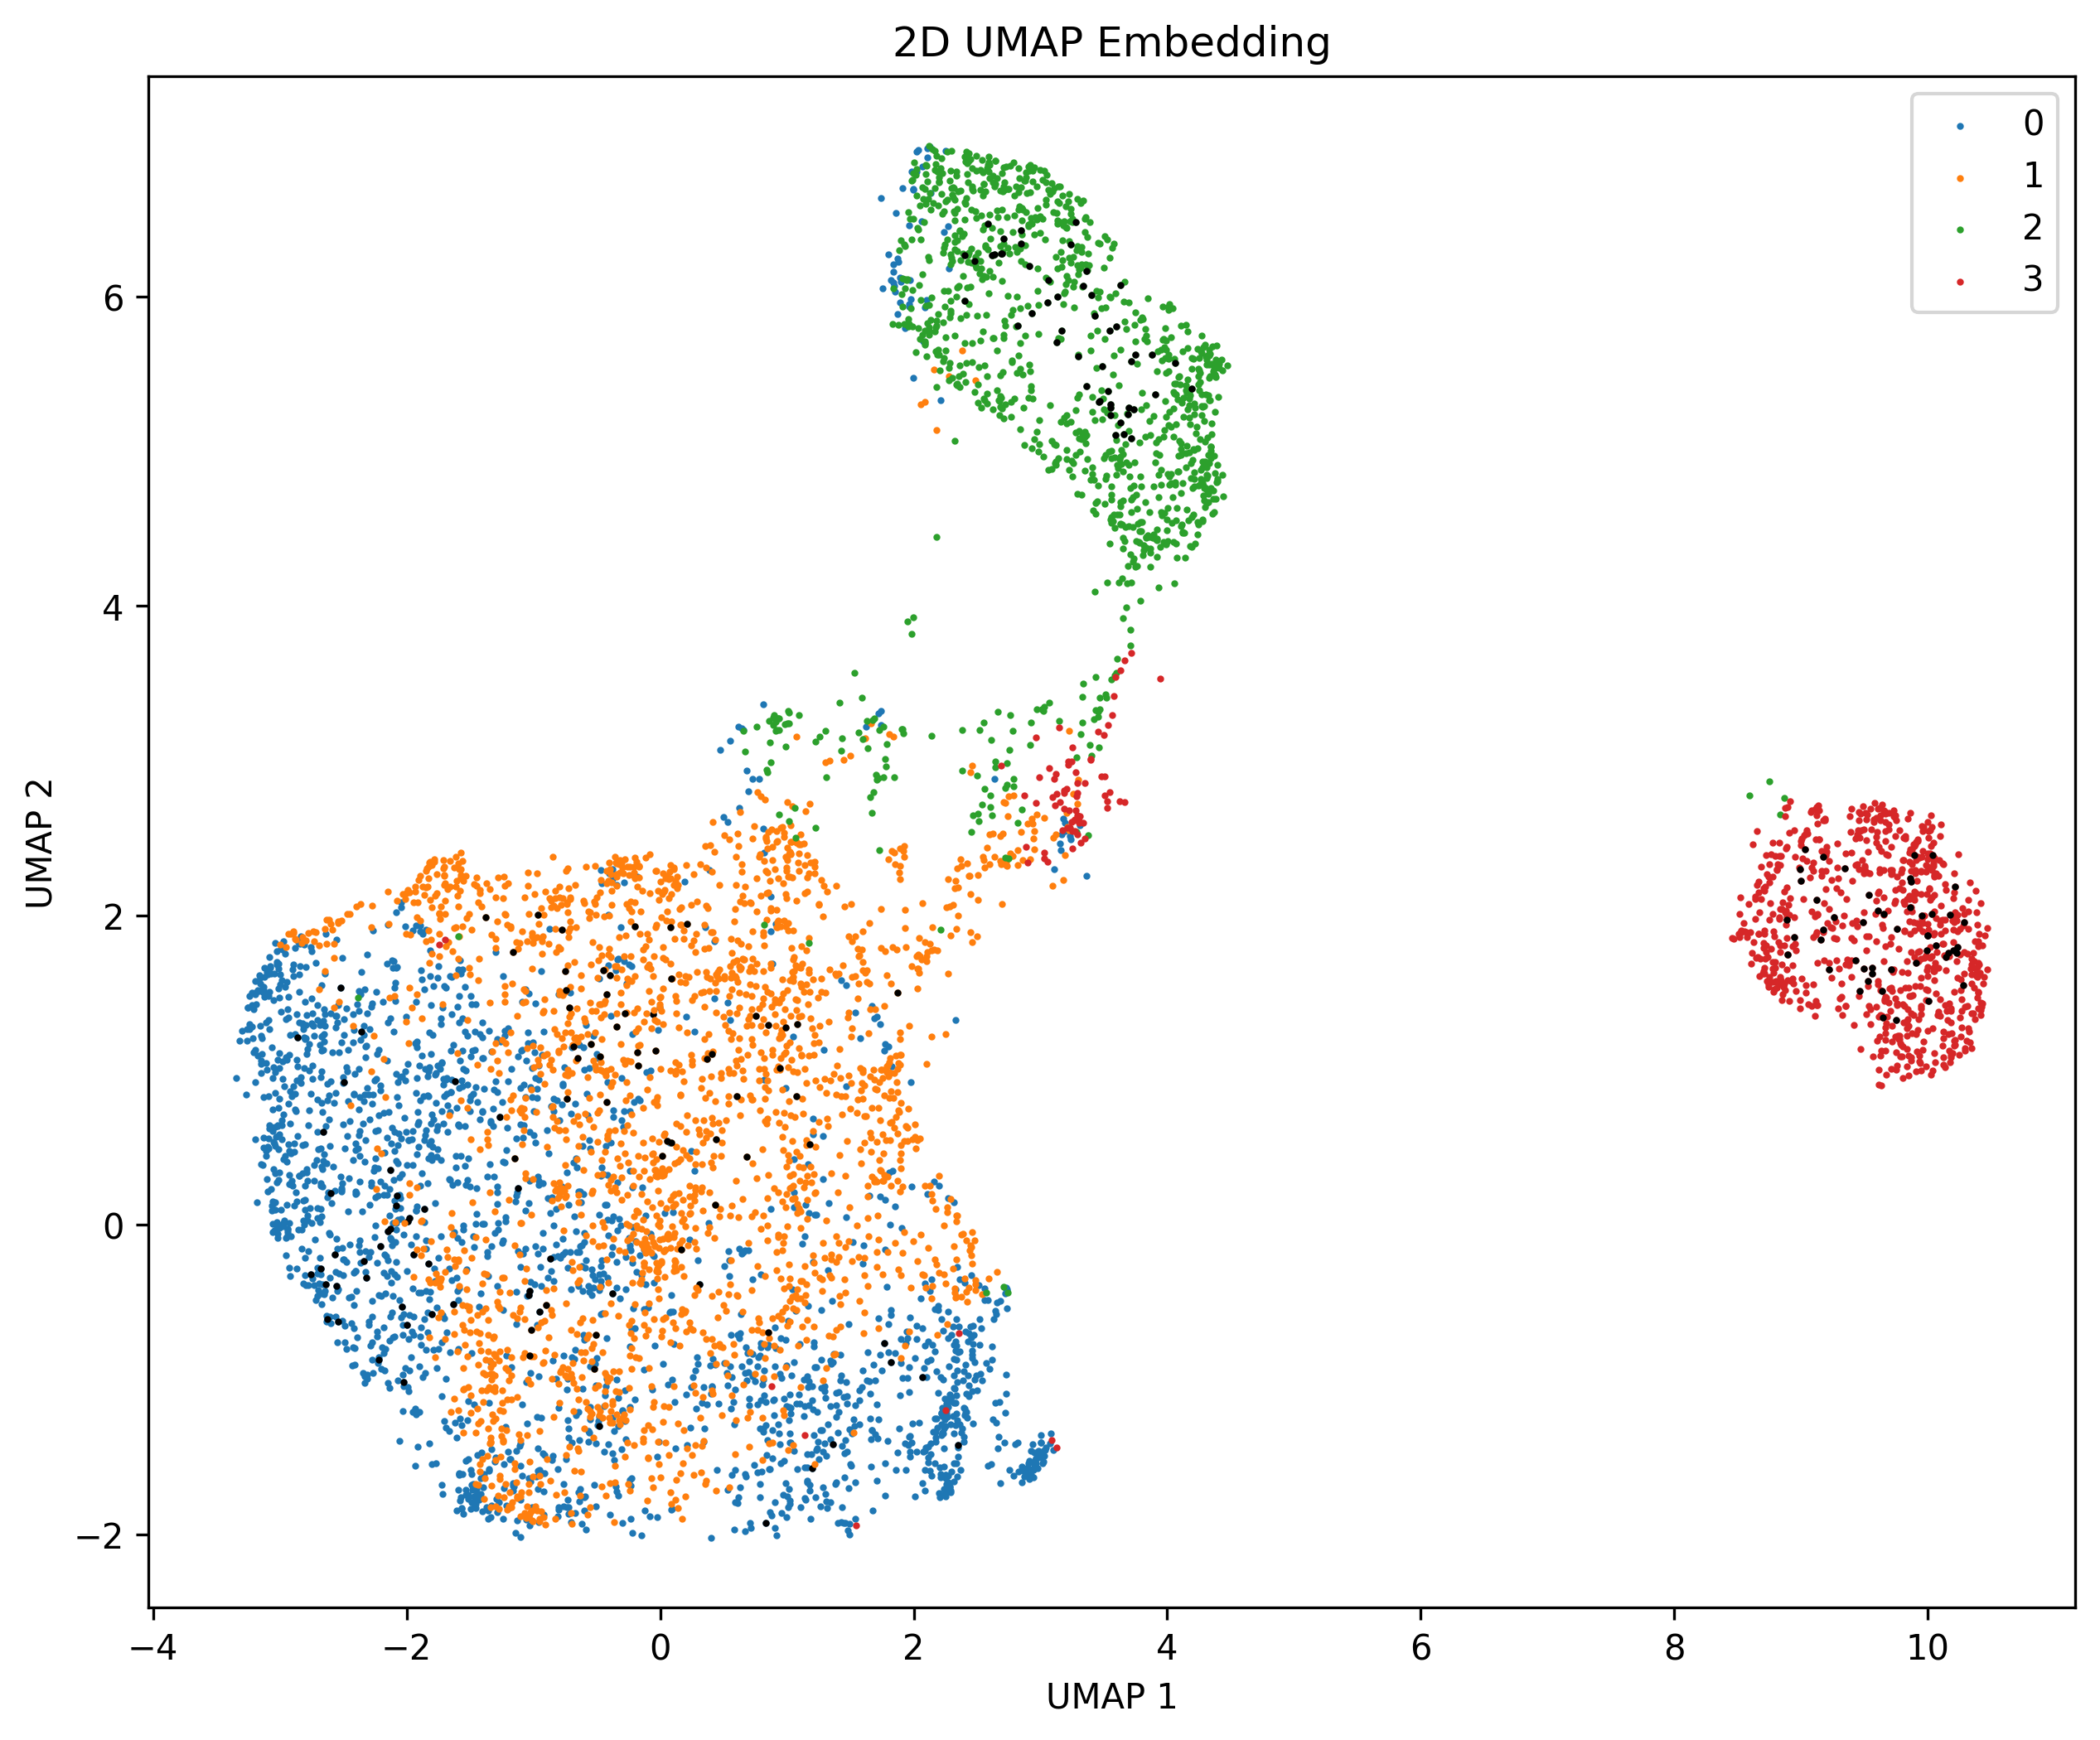

In [20]:
plt.figure(figsize=(10, 8),dpi=300) 
for label in set(knn_prediction):
    indices = knn_prediction == label
    plt.scatter(embedding_2d[indices, 0], embedding_2d[indices, 1],label=label,s=1)  
    
    img_names = all_img_names[nearses_k_index[label]]
    img_names = [ele.rsplit('_',1)[0] for ele in img_names]
    for (point,img_name) in zip (embedding_2d[nearses_k_index[label]],img_names):
        plt.scatter(point[0], point[1],c='black',s=1)
plt.title('2D UMAP Embedding')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.savefig('../results/UMAP_Embedding_pca(kmeans)_intersection.pdf', format='pdf', bbox_inches='tight')
plt.savefig('../results/UMAP_Embedding_pca(kmeans)intersection.png', bbox_inches='tight')